### Import necessary packages

In [809]:
import pulp
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Circle

### Declaring constants for the project

In [810]:
# Number of components to be placed on the motherboard
NUM_COMPONENTS = 11

# Figure width for mat plot lib visualization
FIGURE_WIDTH = 120

# Figure height for mat plot lib visualization
FIGURE_HEIGHT = 8

### Declaring the size of each component
Do note that the RAM memory stick only has a single entry in param_dict as each memory stick has identical dimensions

In [811]:
# Dictionary storing the parameters [height, width] for each component
param_dict = {
    # For square-shaped components, "Component name": [component_length, component_width] 
    # For circular-shaped, "Component name": component_radius
    'chipset':[5,5], 
    'cpu':[3,3], 
    'coolfan': 5, 
    'cmos':2, 
    'bios':[3,3], 
    'powercon':[1,2], 
    'usb':[1,2], 
    'ram':[12,2]
}


### Defining the linear problem and the appropriate linear variables
 
For this project, the LP variables are as follows: 

1. p1: This variable represents the distance between every component (other than the distance between RAM memory sticks) and the edge of the motherboard. 

2. p2: This variable represents the distance between each RAM memory stick. The lower bound value is set to be lower than p1 as there is less wiring required to connect the RAM memory sticks. 

3. (x<sub>i</sub> , y<sub>i</sub>) for 1 $\le$ i $\le$ 11: x<sub>i</sub> and y<sub>i</sub>: The (x<sub>i</sub> , y<sub>i</sub>) variables represent the x-coordinate and y-coordinate for the i-th component

4. width, height: These variables represent the optimised width and height of the motherboard

In [812]:
# Defining the LP
problem = pulp.LpProblem('motherboard', pulp.LpMinimize)

# Defining the variables
p1 = pulp.LpVariable('p1', lowBound=1, cat='Continuous')
p2 = pulp.LpVariable('p2', lowBound=0.8, cat='Continuous')
x = pulp.LpVariable.dicts('x',range(1, NUM_COMPONENTS+1), lowBound=0, cat='Continuous')
y = pulp.LpVariable.dicts('y',range(1, NUM_COMPONENTS+1), lowBound=0, cat='Continuous')
width = pulp.LpVariable('width', lowBound=0, cat='Continuous')
height = pulp.LpVariable('height', lowBound=0, cat='Continuous')

### Adding the objective function to the problem

Since the goal is to minimize the total size of the motherboard, we will be aiming to minimize the perimeter of the motherboard.

In [813]:
# Declaring the objective function
problem += 2*width + 2*height

### Adding horizontal constraints
These constraints only affect the x-coordinate of each component. Kindly refer to the report for the justificaiton of each constraint.

In [814]:
# Adding horizontal constraints

problem += x[1] - p1 >= 0
problem += x[1] + p1 + param_dict['chipset'][1] + param_dict['coolfan'] <= x[3]
problem += x[4] - p1 - param_dict['cmos'] >= 0 
problem += x[5] + param_dict['bios'][1] + p1 + param_dict['coolfan'] <= x[3]
problem += x[4] + p1 + param_dict['cmos'] <= x[5]
problem += x[5] + p1 + param_dict['bios'][1] <= x[6]
problem += x[6] + p1 + param_dict['powercon'][1] <= x[7]
problem += x[7] + p1 + param_dict['usb'][1] <= x[8]
problem += x[3] + p1 + param_dict['coolfan'] <= x[8]
problem += x[8] + p2 + param_dict['ram'][1] <= x[9]
problem += x[9] + p2 + param_dict['ram'][1] <= x[10]
problem += x[10] + p2 + param_dict['ram'][1] <= x[11]
problem += x[11] + p2 + param_dict['ram'][1] <= width


### Adding vertical constraints

These constraints only affect the y-coordinate of each component. Kindly refer to the report for the justificaiton of each constraint.

In [815]:

# Adding vertical constraints
problem += y[4] - p1 - param_dict['cmos'] >= 0
problem += y[4] + p1 + param_dict['cmos'] <= y[1]
problem += y[1] + p1 + param_dict['chipset'][0] <= height
problem += y[5] - p1 >= 0
problem += y[5] + p1 + param_dict['bios'][0] <= y[1]
problem += y[6] - p1 >= 0
problem += y[6] + p1 + param_dict['powercon'][0] + param_dict['coolfan'] <= y[3]
problem += y[3] + p1 + param_dict['coolfan'] <= height
problem += y[7] - p1 >= 0
problem += y[7] + p1 + param_dict['usb'][0] + param_dict['coolfan'] <= y[3]
problem += y[8] - p1 >= 0
problem += y[8] + param_dict['ram'][0] + p2 <= height
problem += y[9] - p1 >= 0
problem += y[9] + param_dict['ram'][0] + p2 <= height
problem += y[10] - p1 >= 0
problem += y[10] + param_dict['ram'][0] + p2 <= height
problem += y[11] - p1 >= 0
problem += y[11] + param_dict['ram'][0] + p2 <= height


### Adding alignment constraints for components

In [816]:

# Adding alignment constraints
problem += x[2] + 0.5*param_dict['cpu'][1] == x[3]
problem += y[2] + 0.5*param_dict['cpu'][0] == y[3]
problem += (x[6] + param_dict['powercon'][1] + x[7])/2 == x[3]
problem += (x[4] + param_dict['cmos'] + x[5])/2 == x[1] + 0.5*param_dict['chipset'][1]
problem += y[2] + 0.5*param_dict['cpu'][0] == y[3]


### Solving the problem

In [817]:
# Solving the problem
problem.solve(pulp.PULP_CBC_CMD(msg=0))

# Creating a dictionary to store the solution
solution = {}
for var in problem.variables():
    solution[var.name] = var.varValue

### Visualisation of the motherboard with matplotlib

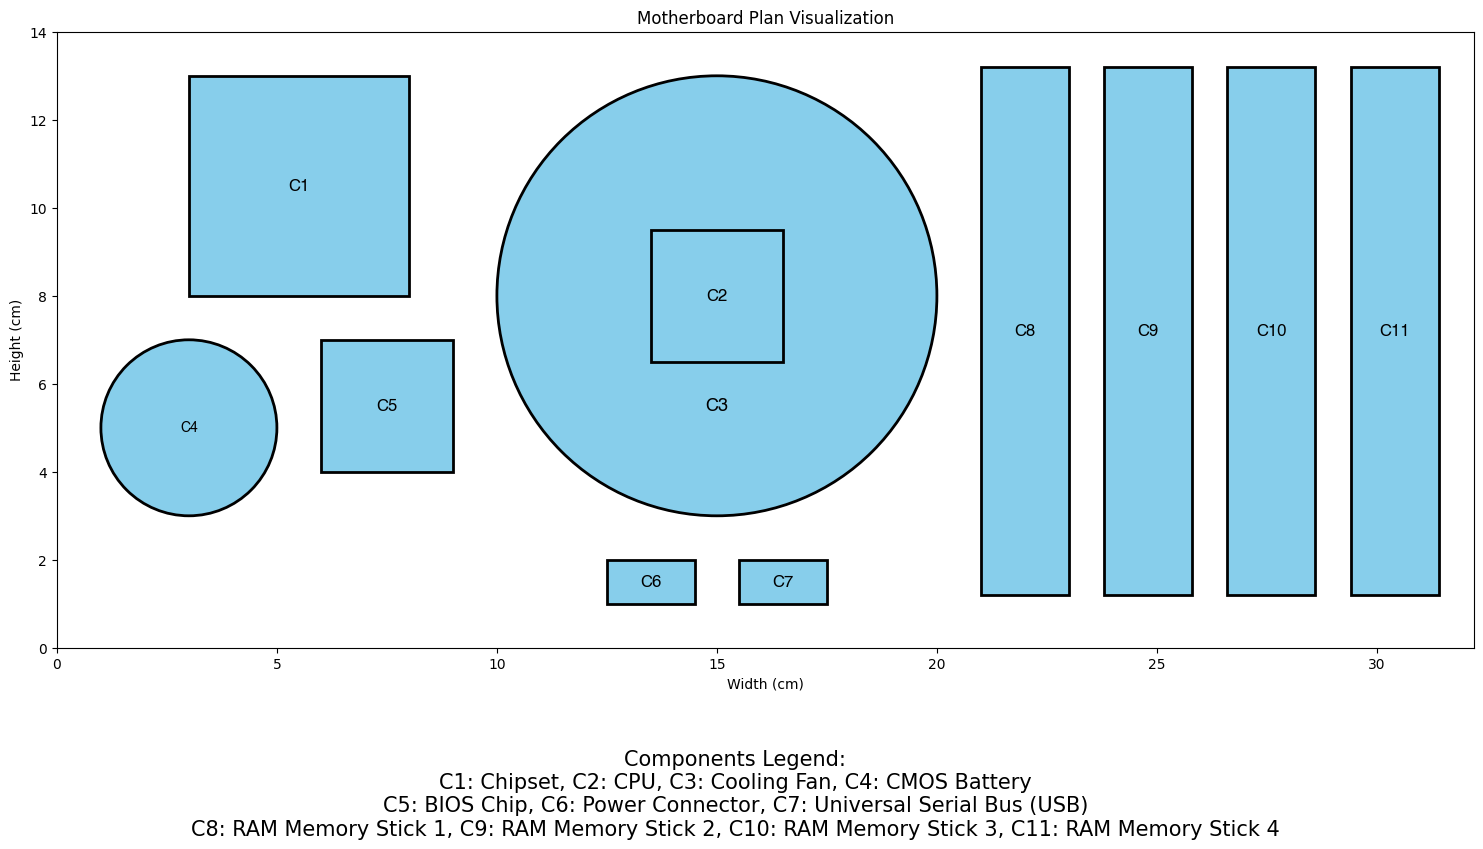

In [819]:
# Dictionary storing font name used for text
hfont = {'fontname':'Helvetica'}


# Dictionary storing the component name
comp_dict = {'C1':'Chipset', 'C2':'CPU', 'C3':'Cooling Fan', 'C4':'CMOS Battery', 'C5':'BIOS Chip', 'C6':'Power Connector', 'C7':'Universal Serial Bus (USB)', 'C8':'RAM Memory Stick 1', 'C9':'RAM Memory Stick 2', 'C10':'RAM Memory Stick 3', 'C11':'RAM Memory Stick 4'}


# Dictionary storing the different rectangular components. 
# Each component is stored as such: {"name": component_name, "x": x-coordinate of component, "y": y-coordinate of component, "width": width of component, "height": height of component}
rectangular_components = [
    {'name': 'C1', 'x': solution["x_1"], 'y': solution["y_1"], 'width': param_dict["chipset"][1], 'height': param_dict["chipset"][0]},
    {'name': 'C2', 'x': solution["x_2"], 'y': solution["y_2"], 'width': param_dict["cpu"][1], 'height': param_dict["cpu"][0]},
    {'name': 'C5', 'x': solution["x_5"], 'y': solution["y_5"], 'width': param_dict["bios"][1], 'height': param_dict["bios"][0]},
    {'name': 'C6', 'x': solution["x_6"], 'y': solution["y_6"], 'width': param_dict["powercon"][1], 'height': param_dict["powercon"][0]},
    {'name': 'C7', 'x': solution["x_7"], 'y': solution["y_7"], 'width': param_dict["usb"][1], 'height': param_dict["usb"][0]},
    {'name': 'C8', 'x': solution["x_8"], 'y': solution["y_8"], 'width': param_dict["ram"][1], 'height': param_dict["ram"][0]},
    {'name': 'C9', 'x': solution["x_9"], 'y': solution["y_9"], 'width': param_dict["ram"][1], 'height': param_dict["ram"][0]},
    {'name': 'C10', 'x': solution["x_10"], 'y': solution["y_10"], 'width': param_dict["ram"][1], 'height': param_dict["ram"][0]},
    {'name': 'C11', 'x': solution["x_11"], 'y': solution["y_11"], 'width': param_dict["ram"][1], 'height': param_dict["ram"][0]},
]

# Dictionary storing the different circular components. 
# Each component is stored as such: {"name": component_name, "x": x-coordinate of component, "y": y-coordinate of component, "radius": radius of component}
circular_components = [
    {'name': 'C3', 'x': solution["x_3"], 'y': solution["y_3"], 'radius': param_dict["coolfan"]},
    {'name': 'C4', 'x': solution["x_4"], 'y': solution["y_4"], 'radius': param_dict["cmos"]},

]

# Create a figure and axis
fig, ax = plt.subplots()

# Declaring the figure width
fig.figure.set_figwidth(FIGURE_WIDTH)

# Declaring the figure height
fig.figure.set_figheight(FIGURE_HEIGHT)

# For loop looping through each component in circular_components dictionary and plotting it on the diagram. Circular components are plotted first so that the cooling fan does not block out the CPU block in the diagram.
for component in circular_components:
    
    # creaing a Circle object for each circular component
    circle = Circle((component["x"], component["y"]), radius=component['radius'], edgecolor='black', facecolor='skyblue', lw=2)

    # Adding the Circle object onto the plot
    ax.add_patch(circle)

    # if-else statement checking for cooling fan component. The cooling fan text is placed at a different coordinates so as to avoid clashing with the CPU
    if component["name"] == "C3":
        # Adding text for cooling fan component on diagram
        ax.text(component['x'],  component['y']-param_dict["coolfan"]/2, component['name'], fontdict= hfont, fontsize=13, ha='center', va='center')
    else:
        # Adding the respective names of other cicular component text on diagram
        ax.text(component['x'],  component['y'], component['name'], fontsize=10, fontdict= hfont, ha='center', va='center')

# For loop looping through each component in rectangular_components dictionary and plotting it on the diagram. 
for component in rectangular_components:

    # creaing a Rectangle object for each rectangular component
    rect = Rectangle((component['x'], component['y']), 
                     component['width'],
                     component['height'],
                     edgecolor='black',
                     facecolor='skyblue', 
                     lw=2)
    
    # Adding the Rectangle object onto the plot
    ax.add_patch(rect)

    # Declaring the x,y variables for each component label
    cx = component['x'] + component['width'] / 2
    cy = component['y'] + component['height'] / 2

    # Adding the respective component name for each rectangular component
    ax.text(cx, cy, component['name'], fontsize=12, fontdict= hfont, ha='center', va='center')


# Setting the limits of the plot based on the components' sizes
ax.set_xlim(0, solution["width"])
ax.set_ylim(0, solution["height"])

# Setting x,y labels and title
ax.set_xlabel('Width (cm)')
ax.set_ylabel('Height (cm)')
ax.set_title('Motherboard Plan Visualization')

# Setting current axes
plt.gca().set_aspect('equal', adjustable='box')

# Removing grid lines from the diagram
plt.grid(False)

# Storing all keys and values from comp_dict in items
items = [f"{key}: {value}" for key, value in comp_dict.items()]

# Calculate the one-third and two-thirds points
third = len(items) // 3
two_thirds = 2 * (len(items) // 3)

# Split the items list into three parts. This ensures that all lines in the legends can be seen.
first_third = ", ".join(items[:third + 1])       # Include the first third
second_third = ", ".join(items[third + 1:two_thirds + 1])  # Include the second third
final_third = ", ".join(items[two_thirds + 1:])  # The rest goes into the final third

# Combine the three thirds with newlines in between
comp_text = "Components Legend:\n" + first_third + "\n" + second_third + "\n" + final_third

# Display the dictionary text below the x-axis using plt.figtext
plt.figtext(0.51, -0.12, comp_text, wrap=True, horizontalalignment='center', fontsize=15)

# Displaying the diagram
plt.show()
